# Building a Classifier using the MNIST Dataset

#### by Yash Bhardwaj  

The following is a personal project of  mine following Aurelion Geron's book on Machine Learning using Scikit-Learn and Tensorflow.

I attempt to build a binary classifier and understand measures of accuracy and fine tuning them for best performance. 

In [1]:
from sklearn.datasets import fetch_openml
import numpy as np
np.random.seed(42)

In [2]:
mnist = fetch_openml('mnist_784',version=1)
mnist.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

In [3]:
X, y = mnist["data"], mnist["target"]
X.shape
   

(70000, 784)

In [4]:
y.shape

(70000,)

There are 70,000 Images with 784 features each. 784 = 28x28 image RGB array. Each feature represents the intensity of a pixel and varies from 0 to 255.

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt

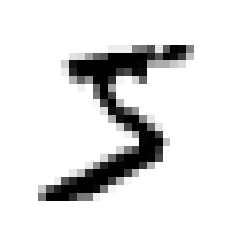

In [6]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation = "nearest")
plt.axis("off")
plt.show()

In [7]:
y[0]

'5'

In [8]:
y = y.astype(np.uint8)

Before we even try to do anything, let us set aside some part of our data as test set, and not touch it until we are done training our model.

In [9]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Let us first start with a binary classifier. That is, classifying images into '5' or non 5 images. 

Create target vectors for this classification task as follows: 

In [10]:
y_train_5 = (y_train == 5)    #True for all 5, False for other digits.
y_test_5 = (y_test == 5)


Stochastic
Gradient Descent (SGD) classifier, using Scikit-Learn’s SGDClassifier class. This clas‐
sifier has the advantage of being capable of handling very large datasets efficiently.
This is in part because SGD deals with training instances independently, one at a time
(which also makes SGD well suited for online learning), as we will see later. Let’s create
an SGDClassifier and train it on the whole training set:

In [11]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [12]:
sgd_clf.predict([some_digit])

array([ True])

## Performance Measures

#### Evaluating a Classifier is more complex than a Regressor. 
Now we will measure accuracy using Cross Validation. 

In [13]:
#Like earlier, let us use Scikit-Learn's cross_val_score() function.

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [14]:
skfolds = StratifiedKFold(n_splits = 3, random_state = 42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.95035
0.96035
0.9604


The StratifiedKFold class performs stratified sampling (as explained in Chapter 2)
to produce folds that contain a representative ratio of each class. At each iteration the
code creates a clone of the classifier, trains that clone on the training folds, and makes
predictions on the test fold. Then it counts the number of correct predictions and
outputs the ratio of correct predictions.

In [15]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [16]:
#Woah the accuracy is way too high.
#Let us see what happens if we classify all images as non-5. 

from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y = None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype = bool)
    

In [17]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")

array([0.91125, 0.90855, 0.90915])

###### Note:-
Even when we classified all images as non 5, we got 90% accuracy. This means that more than 90% of numbers in the MNIST dataset are non-5. Hence the data is highly skewed in this case. 
Hence accuracy is not the preferred performance measure for Classifiers, especially those with skewed datasets like this one. 

### Confusion Matrix

To check the performance of a Classifier, a better way would be to look at the number of errors, or the number of times the classifier classified an image incorrectly. hence we construct a confusion matrix. 
# 

For example, to know the number of times the classifier confused
images of 5s with 3s, you would look in the 5 th row and 3 rd column of the confusion
matrix.

# 

To compute the confusion matrix, you first need to have a set of predictions, so they
can be compared to the actual targets. Let us use cross_val_predict() function for that.

In [18]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)


Just like cross_val_score() performs K-fold cross validation and returns evaluation scores, cross_val predict() does the same, but returns predictions made on each test fold. Also, the prediction in this case is clean as the model does not see the data during training in this case. 

In [19]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

Each row in a confusion matrix represents an actual class, while each column represents a predicted class. The first row of this matrix considers non-5 images (the negative class): 53,892 of them were correctly classified as non-5s (they are called true negatives), while the remaining 687 were wrongly classified as 5s (false positives).
The second row considers the images of 5s (the positive class): 1,891 were wrongly
classified as non-5s (false negatives), while the remaining 3530 were correctly classified as 5s (true positives).

A perfect classifier is suppossed to have only true positives and true negatives so we will simulate that by directly comparing for 100% accuracy taking y-predictions as y-labels

In [20]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

Although the Confusion matrix gives us the exact number of predicitons which were wrong/right, we are more interested in finding another way of measuring accuracy which gives us a clearer picture of the data and its results: 

## Precision :

#### Precision = TP/(TP + FP)

TP - True positives, FP - False positives


Note - If we just make one prediction an ensure that it is a true positive, our acccuracy will become 1/1 = 100% Therefore we use another parameter for measurement of performance:

## Recall / Sensitivity / True positive Rate

#### Recall = TP/(TP + FN)

TP - true positive, FN - False Negative

Scikit-Learn contains functions to calculate precision and recall : 


In [21]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [22]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311


We may combine both precsion and recall into one single parameter called the F1 score. 

##### The F1 score is the harmonic mean of Precision and Recall 

F1 = 2 / (1/precision + 1/recall)  = 2*precision*recall / (precision + recall)

F1 = TP / [TP + (FN + FP)/2]

To compute the F1 score call the f1_score function:

In [23]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

The F1 score favours classifiers that have similar precision and recall. However in some cases we may want more precision without giving less number of fucks to accuracy while in other cases the opposite may be true. 
However there is a tradeoff between Precision and Recall.
In scikit-learn, we can access the deecision scores for each instance and make predicition based on the scores using any threshold we may want.:

In [24]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [25]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [26]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

#### Thus, inscreasing the threshold decreases recall. 
The image was actually a 5, but the classifier does not detect it when the threshold is raised to 8000. 


To decide the threshold, we get thw decision_scores of all the instances in the training set using

In [27]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train, y_train_5, cv = 3, method = "decision_function")
y_scores.shape

(60000, 10)

Note: there was an issue in Scikit-Learn 0.19.0 (fixed in 0.19.1) where the result of cross_val_predict() was incorrect in the binary classification case when using method="decision_function", as in the code above. The resulting array had an extra first dimension full of 0s. Just in case you are using 0.19.0, we need to add this small hack to work around this issue:

In [28]:
if y_scores.ndim == 2:
    y_scores = y_scores[:, 1]

In [29]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores, 1)

#now we can plot the curve using matplotlib

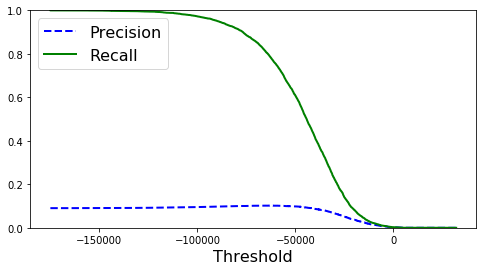

In [30]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)


plt.show()

In [31]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

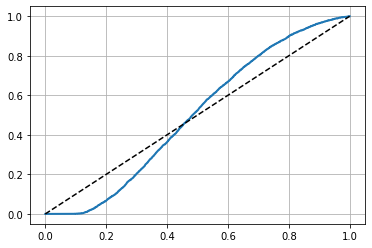

In [33]:
#Plotting FPR against TPR using matplotlib

def plot_roc_curve(fpr, tpr, label = None):
    plt.plot(fpr, tpr, linewidth = 2, label = label)
    plt.plot([0, 1], [0, 1], 'k--')   #dashed diagonal
    plt.grid()
    
    
plot_roc_curve(fpr, tpr)
plt.show()

### The above two curves are totally fucked up. I mean, I probably fucked up in the code even higher up and hopefully I will debug that later ig.

In [34]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.4994240209859942

#### Look bitch, you fucked up real bad. Area under the curve is almost half of what should be expected. 

### Let’s train a RandomForestClassifier and compare its ROC curve and ROC AUC score to the SGDClassifier .

In [36]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state = 42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method = "predict_proba")

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


To plot this along with ROC curve, we need "scores", not "probabilities". So, use the positive class's probability as scores:

In [37]:
y_scores_forest = y_probas_forest[:, 1]    # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

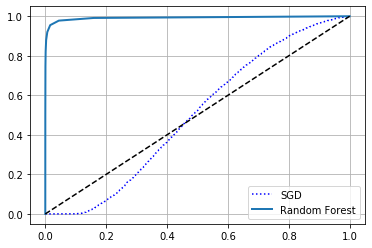

In [39]:
plt.plot(fpr, tpr, "b:", label = "SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

## OH DAMN!

DID YOU SEE THAT? THE RandomForestClassifier works perfectly as expected even though we use the same data but a different algorithm. That means our error lies in the code wherever we have used or called SGD Classifier. 

###### noted. will check that again later.

In [40]:
#calculating "area under curve" or AUC score for RandomForestRegressor:

roc_auc_score(y_train_5, y_scores_forest)

0.9920527492698306

#### comment : NICE.

## Multi-Class Classification

Algorithms that directly classify into multiple classes: naive Bayes and Random Forest Classifiers.

However, there is a way to execute multi-class algorithm using Binary CLassifiers via 2 strategies:

#### One-versus-all or OvA
Get the decision score from each binary classifier for each digit and compare the decision scores from each binary classifier. The one with the highest score is the predicition.

#### One-versus-one or OvO
Train a binary classifier for every pair of digits possible out of the possible digits. This way we end up having to run N(N-1)/2 classifiers. 
    
    That is 45 classifiers for the MNIST datatset. 

Support Vector Machines or (SVM's) perform poorly as the size of the training set increases. So, OvO is preferred in those algorithms as it is faster to train many small classifiers than training a few classifiers on large training sets. However, for most binary classification algorithms, OvA is preferred. 

Scikit-Learn by default uses OvA (except SVM classifiers for which it uses OvO). Let us try this with SGDClassifier:

In [42]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])


array([3], dtype=uint8)

#### In the background, Scikit-Learn actually trained 10 binary classifiers, got their decision scores for the image, and selected the class with the highest score.

In [43]:
#to check, use decision_function() method:

some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores


array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

Note : This time, we got 10 scores, which are for each digit. This confirms the fact that we ran a multi-class classifier. 

In [44]:
np.argmax(some_digit_scores)

3

This means that highest score corresponds to the digit '3'

In [45]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [46]:
sgd_clf.classes_[3]

3

NOTE : When a classifier is trained, it stores the list of target classes in its
classes_ attribute, ordered by value. In this case, the index of each
class in the classes_ array conveniently matches the class itself
(e.g., the class at index 5 happens to be class 5), but in general you
won’t be so lucky.

If we want Scikit-Learn to use OvO or OvA, we can use the OneVsOneClassifier or OneVsAllClassifier classes. SImply create an instance and pass a binary classifier to its constuctor.  Here you go:

In [47]:
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(random_state = 42))

In [48]:
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5], dtype=uint8)

In [49]:
print(len(ovo_clf.estimators_))

45


In [50]:
#Training RandomForestClassifier:

forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


array([5], dtype=uint8)

In [51]:
#getting list of probabilities assigned to each class:

forest_clf.predict_proba([some_digit])

array([[0. , 0. , 0. , 0.2, 0. , 0.8, 0. , 0. , 0. , 0. ]])

In [52]:
#find cross validation scores to evaluate the classifier:

cross_val_score(sgd_clf, X_train, y_train, cv = 3, scoring = "accuracy")

array([0.87082583, 0.87089354, 0.88628294])

In [53]:
# let us scale inputs. That helps improve accuracy. 

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv = 3, scoring = "accuracy")

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([0.89957009, 0.89344467, 0.89963495])

## Error Analysis

Once we have zeroed in on the model that performs the best on out data and have trained it, we try to find out where and why does it run into an error. For this, what we will do is fine-tune hyperparameters using GridSearchCV and automate as much of this process as possible. 

for the analysis of types of errors, we begin with the most basic way to start: Confusion Matrix:

In [54]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv =3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([[5576,    0,   21,    6,    9,   43,   37,    6,  224,    1],
       [   0, 6398,   38,   23,    4,   44,    4,    8,  213,   10],
       [  26,   27, 5242,   90,   71,   26,   62,   36,  371,    7],
       [  24,   17,  117, 5220,    2,  208,   28,   40,  405,   70],
       [  12,   14,   48,   10, 5192,   10,   36,   26,  330,  164],
       [  28,   15,   33,  166,   55, 4437,   76,   14,  538,   59],
       [  30,   14,   41,    2,   43,   95, 5560,    4,  128,    1],
       [  21,    9,   52,   27,   51,   12,    3, 5693,  188,  209],
       [  17,   63,   46,   90,    3,  125,   25,   10, 5429,   43],
       [  23,   18,   31,   66,  116,   32,    1,  179,  377, 5106]])

OKAY. I SEE THAT. I KNOW THAT IS A LOT OF NUMBERS. RIGHT? WHAT DO WE DO IN THAT CASE? 
WE TRY TO LOOK AT AN IMAGE REPRESENTATION OF THE MATRIX DATA using Matplotlib: 

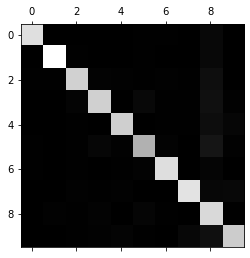

In [57]:
plt.matshow(conf_mx, cmap = plt.cm.gray)
plt.show()

Images on the diagonal were classified correctly. 

Let’s focus the plot on the errors. First, you need to divide each value in the confusion
matrix by the number of images in the corresponding class, so you can compare error rats instead of absolute number of errors. 

In [58]:
row_sums = conf_mx.sum(axis = 1, keepdims = True)
norm_conf_mx = conf_mx / row_sums

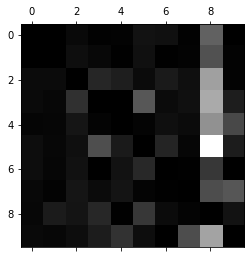

In [59]:
#fill diagonals with zeros to keep only the errors and plot the results:

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap = plt.cm.gray)
plt.show()

Now the kinds of errors the Classifier makes are visible. Rows represent actual classes.

Note : The column of rclass 8 is quite bright.This means that many images get misclassified as 8. However the row for class 8 is not that bad. This means that actual 8s get properly classified as 8s. 

Also note : The confusion matrix is not necessarily symmetrical. Also note that 3s and 5s often get confused with each other (either way). 



#### Plan of action after having noticed patterns in the errors should be to reduce the error in 8s. This can be done by training more data on the digit 8. (also data on digits that look like 8 but aren't 8)

Or we could count the number of loopsin the number like.. 8 has two loops, 6 and 9 have 1 and 2 has none. 

Also we could preprocess the image using Scikit-Image or Pillow or OpenCV to make some pattern stand out more, such as closed loops.

To gain more insight, we can plot some instances of the individual figures of each class.


In [65]:
#ORIGINALLY AVAILABLE FUNCTION FROM THE PDF:
#read and understand this block

def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

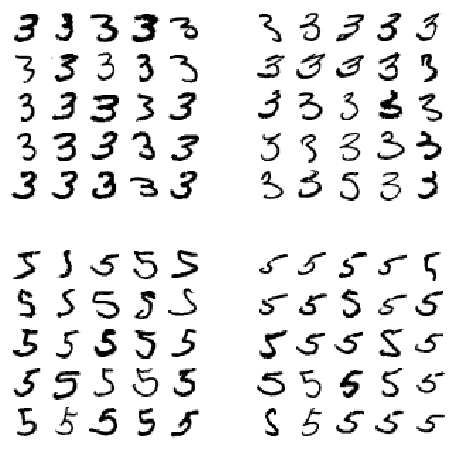

In [66]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]


plt.figure(figsize = (8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row = 5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row = 5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row = 5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row = 5)

plt.show()

The two 5×5 blocks on the left show digits classified as 3s, and the two 5×5 blocks on
the right show images classified as 5s. Some of the digits that the classifier gets wrong
(i.e., in the bottom-left and top-right blocks) are so badly written that even a human
would have trouble classifying them (e.g., the 5 on the 1 st row and 2 nd column truly
looks like a badly written 3). However, most misclassified images seem like obvious
errors to us, and it’s hard to understand why the classifier made the mistakes it did. 3
The reason is that we used a simple SGDClassifier , which is a linear model. All it
does is assign a weight per class to each pixel, and when it sees a new image it just
sums up the weighted pixel intensities to get a score for each class. So since 3s and 5s
differ only by a few pixels, this model will easily confuse them

In [67]:
#MULTI-LABEL CLASSIFICATION

from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [68]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [ ]:
#y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)

#f1_score(y_multilabel, y_train_knn_pred, average="macro")